# Deep Back-Projection Networks (DBPN) for Single Image Super-resolution
### A. Extracting custom Geo data and upscaling using DBPN

In [1]:
from __future__ import print_function
import argparse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from dbpn import Net as DBPN
from dbpn_v1 import Net as DBPNLL
from dbpn_iterative import Net as DBPNITER
from data import get_eval_set
from functools import reduce

# from scipy.misc import imsave
from PIL import Image

import scipy.io as sio
import time
import cv2
from eval import eval

if __name__ == '__main__':
    class ARGS():
        def __init__(self):
            pass
    opt = ARGS()
    opt.weights_file = 'C:/Project_Data/FSRCNN/fsrcnn_x4.pth'
    opt.image_file = 'C:/Project_Data/FSRCNN/0BGE7.jpg'
    opt.upscale_factor = 8
    opt.gpus = 1
    opt.gpu_mode = True
    opt.seed = 22
    opt.test_dataset = 'Set5_LR_x8'
    opt.threads = 1
    opt.testBatchSize = 1
    opt.chop_forward = False
    opt.self_ensemble = False
    opt.residual = False

    opt.input_dir = 'C:/Project_Data/DBPN/geological_pattern_samples/test'
    opt.output = 'C:/Project_Data/DBPN/output'
    opt.model_type = 'DBPNLL'
    opt.model = 'C:/Project_Data/DBPN/models/DBPNLL_x8.pth'
    # opt.model = 'C:/Project_Data/DBPN/my_models/train_sq_DBPNLL_tpami_residual_filter8_epoch_99.pth'
    opt.gpus_list = list(range(opt.gpus))
    print(opt)

    opt.cuda = opt.gpu_mode
    if opt.cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run without --cuda")

    torch.manual_seed(opt.seed)
    if opt.cuda:
        torch.cuda.manual_seed(opt.seed)

    print('===> Loading datasets')
    test_set = get_eval_set(os.path.join(opt.input_dir, opt.test_dataset), opt.upscale_factor)
    testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize,
                                     shuffle=False)

    print('===> Building model')
    if opt.model_type == 'DBPNLL':
        model = DBPNLL(num_channels=3, base_filter=64, feat=256, num_stages=10,
                       scale_factor=opt.upscale_factor)  ###D-DBPN
    elif opt.model_type == 'DBPN-RES-MR64-3':
        model = DBPNITER(num_channels=3, base_filter=64, feat=256, num_stages=3,
                         scale_factor=opt.upscale_factor)  ###D-DBPN
    else:
        print('model: else')
        model = DBPN(num_channels=3, base_filter=64, feat=256, num_stages=7, scale_factor=opt.upscale_factor)  ###D-DBPN

    if opt.cuda:
        model = torch.nn.DataParallel(model, device_ids=opt.gpus_list)

    model.load_state_dict(torch.load(opt.model, map_location=lambda storage, loc: storage), strict=True)
    print('Pre-trained SR model is loaded.')

    if opt.cuda:
        model = model.cuda(opt.gpus_list[0])



    ##Eval Start!!!!
    eval(opt, model, testing_data_loader)

===> Loading datasets
===> Building model
Pre-trained SR model is loaded.
===> Processing: 10_resize.jpg || Timer: 0.9840 sec.
===> Processing: 11_resize.jpg || Timer: 0.0210 sec.
===> Processing: 12_resize.jpg || Timer: 0.0300 sec.
===> Processing: 13_resize.jpg || Timer: 0.0280 sec.
===> Processing: 14_resize.jpg || Timer: 0.0260 sec.
===> Processing: 15_resize.jpg || Timer: 0.0270 sec.
===> Processing: 16_resize.jpg || Timer: 0.0210 sec.
===> Processing: 17_resize.jpg || Timer: 0.0290 sec.
===> Processing: 1_resize.jpg || Timer: 0.0270 sec.
===> Processing: 2_resize.jpg || Timer: 0.0230 sec.
===> Processing: 3_resize.jpg || Timer: 0.0230 sec.
===> Processing: 4_resize.jpg || Timer: 0.0240 sec.
===> Processing: 5_resize.jpg || Timer: 0.0300 sec.
===> Processing: 6_resize.jpg || Timer: 0.0270 sec.
===> Processing: 7_resize.jpg || Timer: 0.0250 sec.
===> Processing: 8_resize.jpg || Timer: 0.0220 sec.
===> Processing: 9_resize.jpg || Timer: 0.0250 sec.


#### Preview of collected high resolution geological images in order to evaluate performance of DBPN model

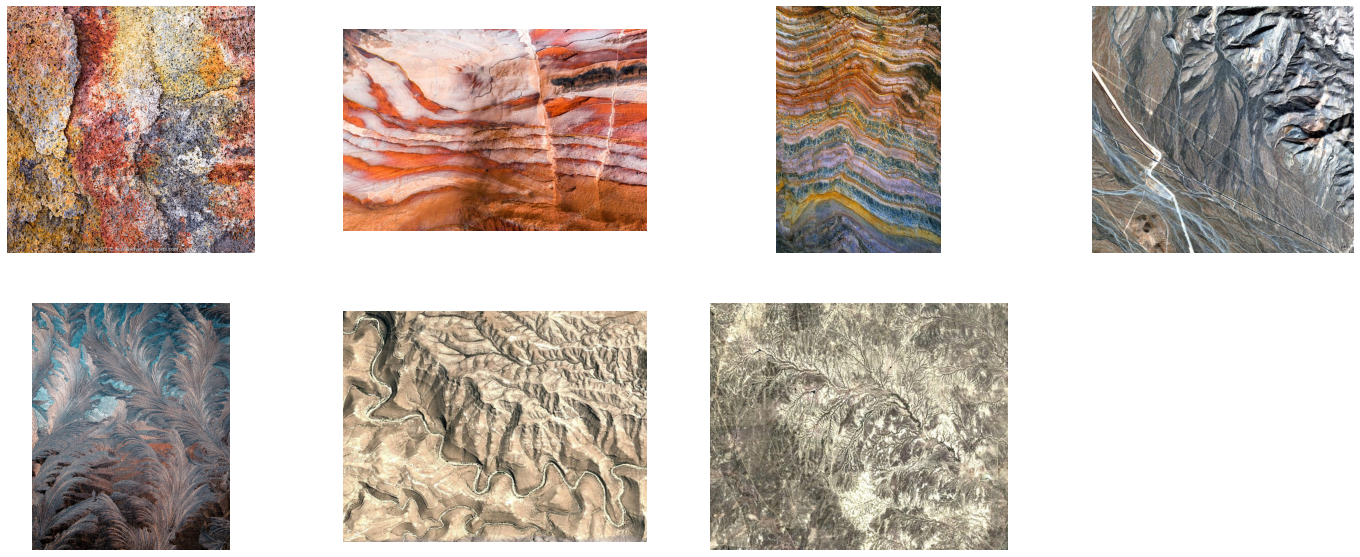

In [30]:
import sys 
sys.path.append('..')
from utils_my import images_show, image_gallery, geo_dict
import os
geo_path = 'C:/Project_Data/DBPN/geological_pattern_samples/test/orig/'
images_list, target_list = [], []

# print('indexing', label, '... ')
# time.sleep(0.3)
label_path = geo_path#os.path.join(geo_path, label).replace("\\", "/")
images = [label_path + '/' + img for img in os.listdir(label_path)[:60]]
targets = [geo_dict[label]] * len(images)
images_list.extend(images)
target_list.extend(targets)
image_gallery(images, [label] * len(images), columns=4, figsize=(25, 10), class_show=False, title_show=False)

### B. Comparing DBPN and Bicubic using Similarity Measurements (PSNR, SSIM, and DTW)

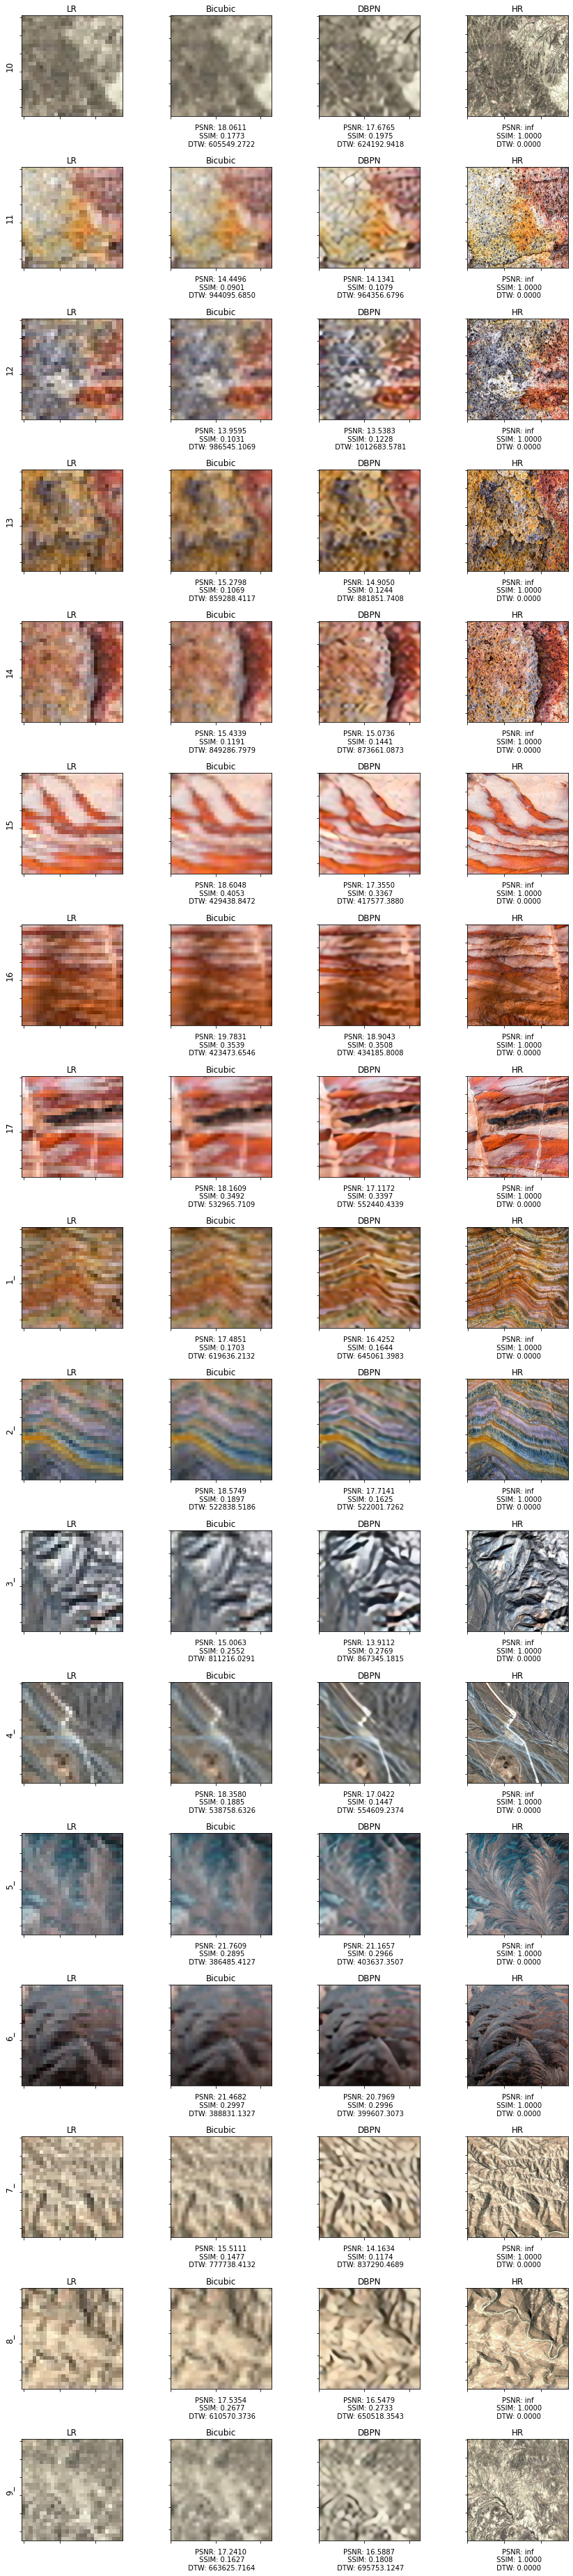

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb
import numpy as np
from PIL import Image
from dtw import *

im_size = (224, 224)
subfolders = [   'C:/Project_Data/DBPN/geological_pattern_samples/test/Set5_LR_x8',
                 'C:/Project_Data/DBPN/output/out_8x_bicubic/',
                 'C:/Project_Data/DBPN/output/Set5_LR_x8/',
                 'C:/Project_Data/DBPN/geological_pattern_samples/test/Set5_HR_x8 - orig']
imagelist = []
filelist = []
for idx, subfolder in enumerate(subfolders):
    filenames = [f.path for f in os.scandir(subfolder)]
    filelist.append(filenames)
    #filenames.sort()
    images = [Image.open(im_path).convert('RGB') for im_path in filenames]
    if idx > 0:
        # check images size and resize if necessary for other HR images
        images = [np.array(im.resize(size=im_size)) if np.array(im).shape[:2]!=im_size else np.array(im) for im in images]
    else:
        images = [np.array(im) for im in images]
    imagelist.append(images)
    
n_show = 17
w=.2
titles = ['LR', 'Bicubic', 'DBPN', 'HR']
fig, axes = plt.subplots(n_show, len(subfolders), figsize = (12,n_show*3))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
# Preview images:
for col_idx, subfolder in enumerate(subfolders):
    for row_idx, path in enumerate(filelist[col_idx]):
        image = pltimg.imread(path)
        if col_idx==0:
#             axes[row_idx, col_idx].imshow(image, origin = 'lower', extent=[0, 28, 0, 28], aspect=1)
            axes[row_idx, col_idx].imshow(image)
        else:
            axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])
        if col_idx>=1:
            ir, iq = np.array(imagelist[3][row_idx]), np.array(imagelist[col_idx][row_idx])
            axes[row_idx, col_idx].set_xlabel('PSNR: {:.4f}\n SSIM: {:.4f}\n DTW: {:.4f}'.
                                              format(psnr(ir, iq),
                                                     ssim(ir, iq)[0],
                                                     dtw(ir.reshape(ir.shape[0]*ir.shape[2], ir.shape[1]), 
                                                         iq.reshape(iq.shape[0]*iq.shape[2], iq.shape[1]), 
                                                              distance_only=True, keep_internals=False).distance))
        axes[row_idx, col_idx].set_title(titles[col_idx])

# Set labels:
for ax, f in zip(axes[:,0], filenames):
    ax.set_ylabel(f.split('\\')[-1][:2], rotation=90, size='large')
#     ax.set_xlabel(r"My long label with unescaped {\LaTeX} $\Sigma_{C}$ math"
#                        "\n"  # Newline: the backslash is interpreted as usual
#                        r"continues here with $\pi$", rotation=0, size='large')

plt.show()

### Up scaling Geo sample data using DBPN model

In [2]:
from __future__ import print_function
import argparse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from dbpn import Net as DBPN
from dbpn_v1 import Net as DBPNLL
from dbpn_iterative import Net as DBPNITER
from data import get_eval_set
from functools import reduce

# from scipy.misc import imsave
from PIL import Image

import scipy.io as sio
import time
import cv2
from eval import eval, geo_dict

class ARGS():
    def __init__(self):
        pass
opt = ARGS()
opt.weights_file = 'C:/Project_Data/FSRCNN/fsrcnn_x4.pth'
opt.image_file = 'C:/Project_Data/FSRCNN/0BGE7.jpg'
opt.upscale_factor = 8
opt.gpus = 1
opt.gpu_mode = True
opt.seed = 22
opt.test_dataset = 'Set5_LR_x8'
opt.threads = 1
opt.testBatchSize = 1
opt.chop_forward = False
opt.self_ensemble = False
opt.residual = False

opt.input_dir = 'C:/Project_Data/geological_similarity/'
opt.output = 'C:/Project_Data/DBPN/output'
opt.model_type = 'DBPNLL'
opt.model = 'C:/Project_Data/DBPN/models/DBPNLL_x8.pth'
# opt.model = 'C:/Project_Data/DBPN/my_models/train_sq_DBPNLL_tpami_residual_filter8_epoch_99.pth'
opt.gpus_list = list(range(opt.gpus))
print(opt)

opt.cuda = opt.gpu_mode
if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)
if opt.cuda:
    torch.cuda.manual_seed(opt.seed)

print('===> Building model')
if opt.model_type == 'DBPNLL':
    model = DBPNLL(num_channels=3, base_filter=64, feat=256, num_stages=10,
                   scale_factor=opt.upscale_factor)  ###D-DBPN
elif opt.model_type == 'DBPN-RES-MR64-3':
    model = DBPNITER(num_channels=3, base_filter=64, feat=256, num_stages=3,
                     scale_factor=opt.upscale_factor)  ###D-DBPN
else:
    print('model: else')
    model = DBPN(num_channels=3, base_filter=64, feat=256, num_stages=7, scale_factor=opt.upscale_factor)  ###D-DBPN

if opt.cuda:
    model = torch.nn.DataParallel(model, device_ids=opt.gpus_list)

model.load_state_dict(torch.load(opt.model, map_location=lambda storage, loc: storage), strict=True)
print('Pre-trained SR model is loaded.')

if opt.cuda:
    model = model.cuda(opt.gpus_list[0])





slice = 20
for folder in geo_dict.keys():
    opt.test_dataset = folder
    print('===> Loading datasets')
    print(os.path.join(opt.input_dir, opt.test_dataset))
    test_set = get_eval_set(os.path.join(opt.input_dir, opt.test_dataset), opt.upscale_factor)
    test_set.image_filenames = test_set.image_filenames[:slice]
    testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize,
                                     shuffle=False)




    ##Eval Start!!!!
    eval(opt, model, testing_data_loader)

===> Building model
Pre-trained SR model is loaded.
===> Loading datasets
C:/Project_Data/geological_similarity/andesite
===> Processing: 012L6.jpg || Timer: 0.9890 sec.
===> Processing: 01ITR.jpg || Timer: 0.0270 sec.
===> Processing: 01LQQ.jpg || Timer: 0.0240 sec.
===> Processing: 0230P.jpg || Timer: 0.0260 sec.
===> Processing: 02741.jpg || Timer: 0.0240 sec.
===> Processing: 02Q0N.jpg || Timer: 0.0260 sec.
===> Processing: 02UT8.jpg || Timer: 0.0280 sec.
===> Processing: 02V0N.jpg || Timer: 0.0210 sec.
===> Processing: 031XF.jpg || Timer: 0.0280 sec.
===> Processing: 03GPU.jpg || Timer: 0.0240 sec.
===> Processing: 03OSJ.jpg || Timer: 0.0270 sec.
===> Processing: 03PIF.jpg || Timer: 0.0290 sec.
===> Processing: 03VGY.jpg || Timer: 0.0250 sec.
===> Processing: 03X8U.jpg || Timer: 0.0280 sec.
===> Processing: 03XGF.jpg || Timer: 0.0270 sec.
===> Processing: 03Z9A.jpg || Timer: 0.0250 sec.
===> Processing: 041BX.jpg || Timer: 0.0290 sec.
===> Processing: 049S1.jpg || Timer: 0.0250 se

### C. Create bicubic images from geo dataset

In [5]:
import os
from shutil import copyfile, copy, copy2, copyfileobj
import PIL
from PIL import Image
from tqdm import tqdm

directory = 'C:/Project_Data/geological_similarity/'
for path, subdirs, files in os.walk(directory):
    break

# resize to  8X images and copy to subfolders
dst_dir = 'C:/Project_Data/DBPN/output/classes_8x_bicubic/'
# img_dir = 'C:/Project_Data/geological_similarity_8x/images/'

img_size = (224, 224)

for subdir in subdirs:
    if not os.path.exists(dst_dir+subdir):
        os.makedirs(dst_dir+subdir)
for subdir in subdirs:
    for img_file in tqdm(os.listdir(directory + subdir)[:slice]):
        im = Image.open(directory + subdir + '/' + img_file)
        im_out = im.resize(size=img_size, resample=PIL.Image.BICUBIC, box=None)
        im_out.save(dst_dir+subdir+'/'+img_file)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 512.85it/s]


### D. Preview of reconstructed LR images using DPBN and compare them visually with BICUBIC up-scaled

In this section, we can see the up-scaled images using DPBN has a bit sharper edges with more details than Bicubic up-scaled images. 

For each class of the Geo dataset, a few images have been selected and below is a comparison between them with the state of the art super resolution algorithm


Class Name: andesite


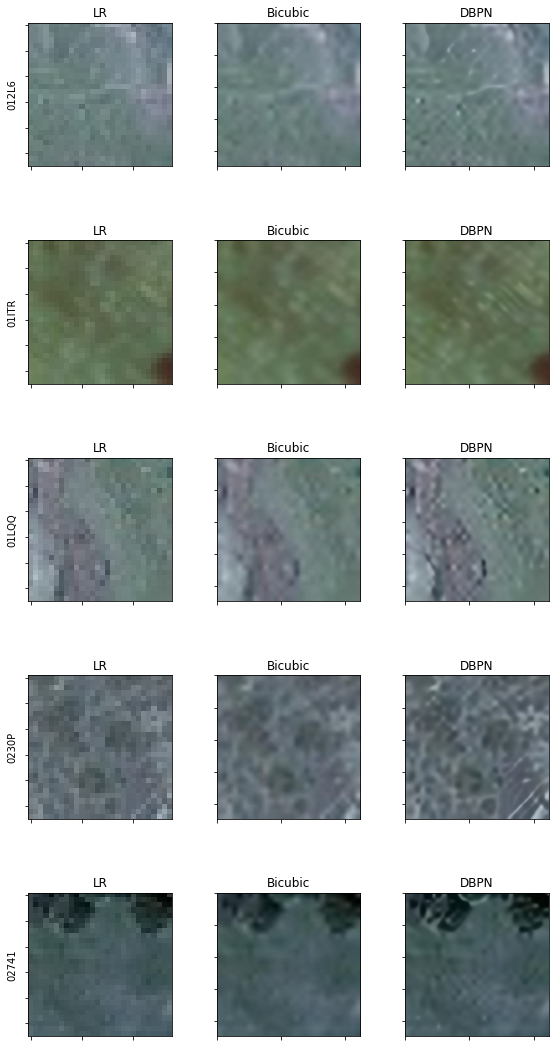

Class Name: gneiss


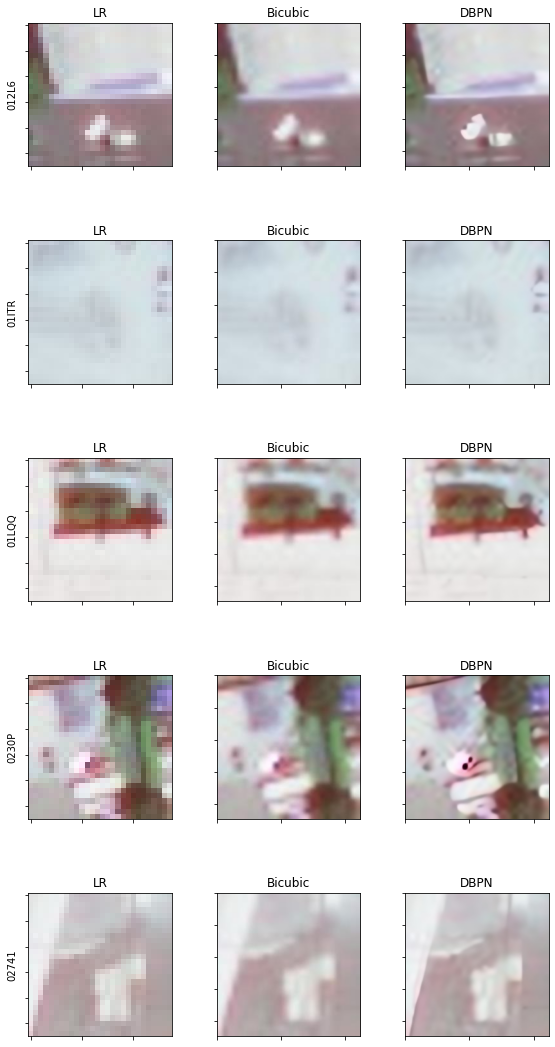

Class Name: marble


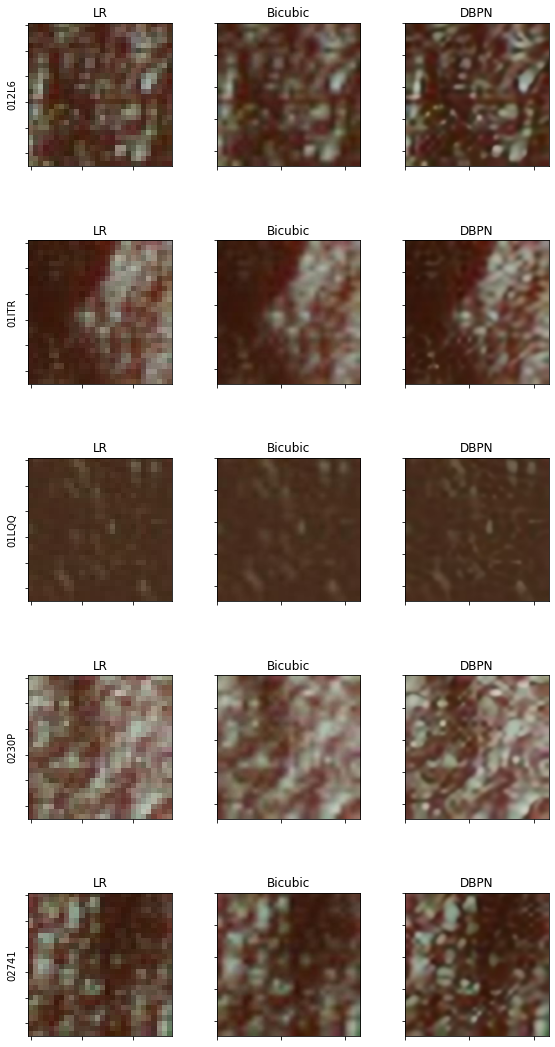

Class Name: quartzite


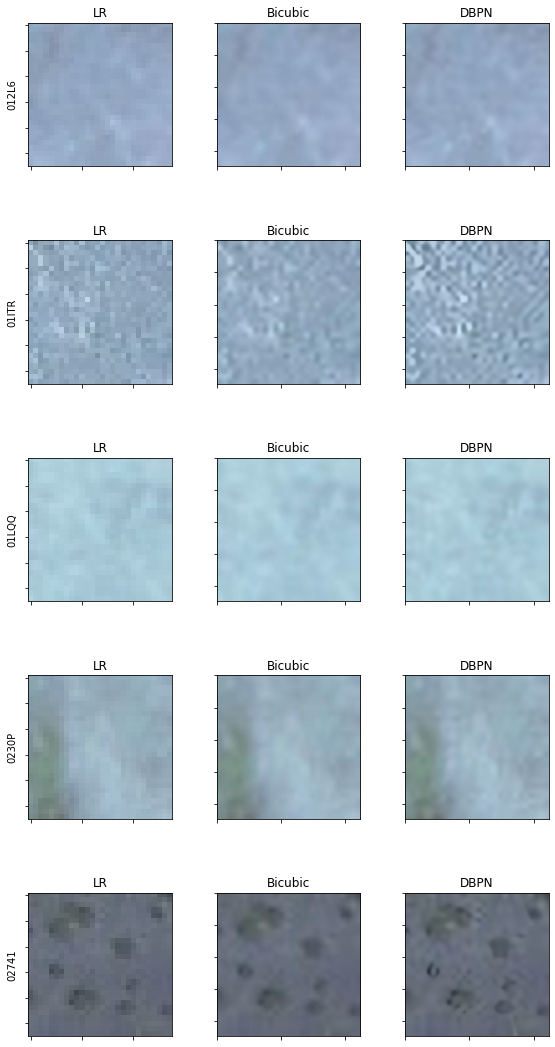

Class Name: rhyolite


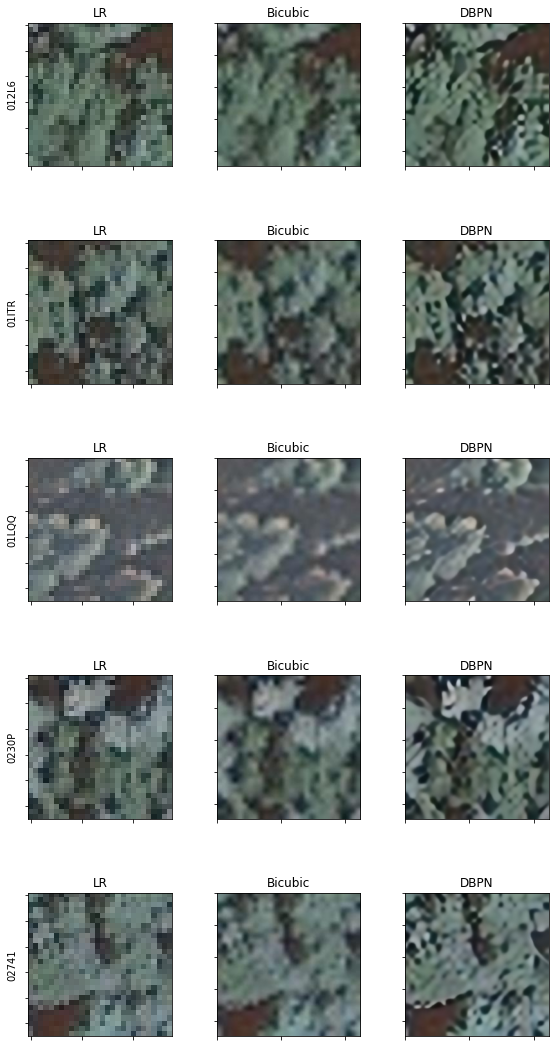

Class Name: schist


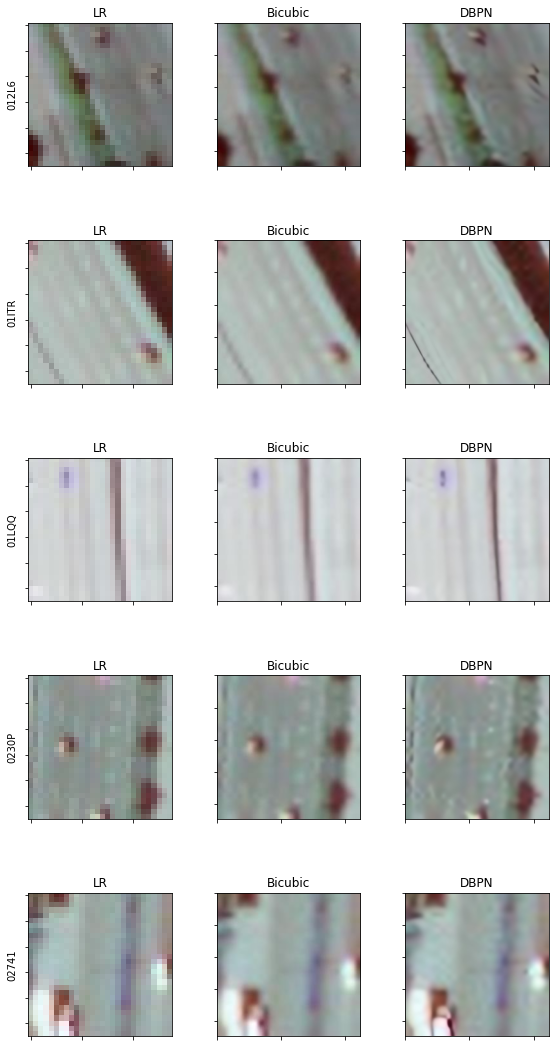

In [17]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb
import numpy as np
from PIL import Image
from eval import geo_dict
import itertools

slice = 5
im_size = (224, 224)
paths = [    'C:/Project_Data/geological_similarity/',
             'C:/Project_Data/DBPN/output/classes_8x_bicubic/',
             'C:/Project_Data/DBPN/output/']
imagelist = []
filelist = []
for class_name in geo_dict.keys():
    ilst, flst = [], []
    for idx, path in enumerate(paths):
        filenames = [f.path for f in itertools.islice(os.scandir(path + class_name), 0, slice)]
        flst.append(filenames)
        #filenames.sort()
        images = [Image.open(im_path).convert('RGB') for im_path in filenames]
        if idx > 0:
            # check images size and resize if necessary for other HR images
            images = [np.array(im.resize(size=im_size)) if np.array(im).shape[:2]!=im_size else np.array(im) for im in images]
        else:
            images = [np.array(im) for im in images]
        ilst.append(images)
    filelist.append(flst)
    imagelist.append(ilst)
    

# Preview images:
for cls_idx, class_name in enumerate(geo_dict.keys()):
    print("Class Name: {}".format(class_name))
    n_show = slice
    w=.2
    titles = ['LR', 'Bicubic', 'DBPN', 'HR']
    fig, axes = plt.subplots(n_show, len(paths), figsize = (8, n_show*3))
    fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
    for col_idx, path in enumerate(paths):
        for row_idx, fname in enumerate(filelist[cls_idx][col_idx]):
            image = pltimg.imread(fname)
            if col_idx==0:
    #             axes[row_idx, col_idx].imshow(image, origin = 'lower', extent=[0, 28, 0, 28], aspect=1)
                axes[row_idx, col_idx].imshow(image)
            else:
                axes[row_idx, col_idx].imshow(image)
            axes[row_idx, col_idx].set_xticklabels([])
            axes[row_idx, col_idx].set_yticklabels([])
#             if col_idx>=1:
#                 axes[row_idx, col_idx].set_xlabel('PSNR: {:.4f}\n SSIM: {:.4f}'.
#                                                   format(psnr(imagelist[3][row_idx], imagelist[col_idx][row_idx]),
#                                                         ssim(imagelist[3][row_idx], imagelist[col_idx][row_idx])[0]))
            axes[row_idx, col_idx].set_title(titles[col_idx])

    # Set labels:
    for ax, f in zip(axes[:,0], filelist[0][0]):
        ax.set_ylabel(f.split('\\')[-1].split('.')[0], rotation=90, size='medium')
    #     ax.set_xlabel(r"My long label with unescaped {\LaTeX} $\Sigma_{C}$ math"
    #                        "\n"  # Newline: the backslash is interpreted as usual
    #                        r"continues here with $\pi$", rotation=0, size='large')

    plt.show()

In [12]:
f.split('\\')[-1].split('.')[0]

'04NZL'